### MiniRAST Analysis

This is just an example of a couple of fields so we can identify which countries are important. See `RAST Sources` for a full notebook 

In [1]:
# some of these are not needed!
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
import seaborn as sns
import numpy as np

import math
import re

from PhiSpyAnalysis import theils_u, DateConverter, printmd
from PhiSpyAnalysis import read_phages, read_gtdb, read_checkv, read_base_pp, read_categories, read_metadata

from scipy.stats import pearsonr, f_oneway
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, LeaveOneGroupOut
from sklearn import metrics

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd, tukeyhsd, MultiComparison
from statsmodels.multivariate.manova import MANOVA
from sklearn import decomposition
from sklearn.ensemble import RandomForestClassifier

from PhiSpyAnalysis import theils_u, DateConverter


import subprocess
import gzip


In [2]:
phagesdf = read_phages()

Please note that this was run with git commit 1a2a28b that has 567,404 genomes parsed.
Initially there were 3,265,453 kept phages, but after filtering we kept 1,961,109 prophages from 388,797 genomes

### The assembly accession ID column

PATRIC calls the column `assembly_accession` while GTDB calls it `ncbi_genbank_assembly_accession`

In [3]:
acccol = 'assembly_accession'

In [4]:
metadf = read_metadata()

## Read some categories

In [5]:
catdf = read_categories()
catdf

,assembly_accession,Category,Biome
0,GCA_000003645.1,food,Terrestrial
1,GCA_000003925.1,soil,Terrestrial
2,GCA_000003955.1,human blood,Host-Associated
3,GCA_000005825.2,soil,Terrestrial
4,GCA_000006155.2,human other,Host-Associated
...,...,...,...
54640,GCA_902860175.1,built environment,Terrestrial
54641,GCA_902860185.1,human other,Host-Associated
54642,GCA_902860195.1,human other,Host-Associated
54643,GCA_902860235.1,plant,Terrestrial


In [6]:
interesting_cols = [acccol, 'isolation_country', 'isolation_date']

tempdf = metadf[interesting_cols]
# tempdf = metadf[few_interesting_cols]
temp1 = pd.merge(tempdf, catdf, how='left', left_on=acccol, right_on=acccol)
# phagemeta = pd.merge(tempdf, phagesdf, how='inner', left_on=acccol, right_on=acccol)
# phagemeta.to_csv(os.path.join('results', 'example_isolations.tsv'), sep='\t')

phagemeta = pd.merge(temp1, phagesdf, how='right', left_on=acccol, right_on=acccol)
phagemeta

,assembly_accession,isolation_country,isolation_date,Category,Biome,assembly_name,Genome length,Contigs,Phage Contigs,Total Predicted Prophages,Kept,No phage genes,Not enough genes,bp prophage
0,GCA_000043285.1,NaN,NaN,NaN,NaN,ASM4328v1,705557.0,1.0,1.0,2.0,0.0,2.0,0.0,0.0
1,GCA_000046685.1,France,1993.306639,human blood,Host-Associated,ASM4668v1,1581384.0,1.0,1.0,18.0,3.0,0.0,15.0,97011.0
2,GCA_000046705.1,United States,NaN,human blood,Host-Associated,ASM4670v1,1931047.0,1.0,1.0,36.0,7.0,0.0,29.0,278490.0
3,GCA_000046845.1,NaN,1957.958248,soil,Terrestrial,ASM4684v1,3598621.0,1.0,1.0,13.0,3.0,4.0,6.0,83112.0
4,GCA_000047365.1,NaN,NaN,human other,Host-Associated,ASM4736v1,4840898.0,3.0,3.0,22.0,3.0,3.0,16.0,213427.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388792,GCA_905187425.1,NaN,NaN,NaN,NaN,Xanthomonas_sp._CPBF_424_-_hybrid_assembly,4900930.0,1.0,1.0,46.0,7.0,9.0,30.0,214278.0
388793,GCA_905188235.1,NaN,NaN,NaN,NaN,ASM90518823v1,4963609.0,1.0,1.0,29.0,4.0,4.0,21.0,178993.0
388794,GCA_905219375.1,NaN,2015.915811,NaN,NaN,QI0054,3034314.0,1.0,1.0,12.0,4.0,3.0,5.0,178527.0
388795,GCA_905219385.1,NaN,2015.138261,NaN,NaN,QI0055,3034113.0,1.0,1.0,12.0,4.0,3.0,5.0,178526.0


## Encode the data

In [7]:
pmenc = pd.DataFrame()
for c in ['isolation_country', 'Category']:
    pmenc[c] = phagemeta[c].astype('category').cat.codes
pmenc['isolation_date'] = phagemeta['isolation_date'].fillna(-1)
pmenc

,isolation_country,Category,isolation_date
0,-1,-1,-1.000000
1,63,14,1993.306639
2,209,14,-1.000000
3,-1,46,1957.958248
4,-1,22,-1.000000
...,...,...,...
388792,-1,-1,-1.000000
388793,-1,-1,-1.000000
388794,-1,-1,2015.915811
388795,-1,-1,2015.138261


In [8]:
# print a list of the countries and their IDs for the LOGO analysis.
seen=set()
for index, row in phagemeta.iterrows():
    if pmenc.loc[index, 'isolation_country'] not in seen:
        print(f"{pmenc.loc[index, 'isolation_country']}\t{phagemeta.loc[index, 'isolation_country']}")
        seen.add(pmenc.loc[index, 'isolation_country'])

-1	nan
63	France
209	United States
64	French Guiana
150	Peru
91	Italy
201	Tunisia
93	Japan
37	China
138	North Sea
27	Brazil
154	Portugal
143	Pacific Ocean
86	Indonesia
141	Norway
193	Taiwan
170	Senegal
18	Bangladesh
59	Ethiopia
191	Switzerland
83	Iceland
178	South Africa
12	Australia
180	South Korea
169	Sea of Korea
15	Bahamas
139	Northern Ireland
68	Germany
62	Finland
6	Antarctica
208	United Kingdom
131	Netherlands
128	Myanmar
32	Canada
11	Atlantic Ocean
197	Thailand
162	Russia
17	Baltic Sea
130	Nepal
159	Republic of the Congo
69	Ghana
24	Black Sea
7	Arabian Sea
166	Sargasso Sea
82	Hungary
133	New Zealand
155	Puerto Rico
50	Denmark
204	USSR
195	Tanzania
144	Pakistan
120	Mediterranean Sea
113	Malaya
72	Guadeloupe
151	Philippine Sea
184	Spain
121	Mexico
214	Viet Nam
84	India
39	Colombia
114	Malaysia
205	Uganda
216	Zambia
78	Haiti
217	Zimbabwe
9	Argentina
167	Saudi Arabia
157	Red Sea
71	Greenland
207	United Arab Emirates
153	Poland
21	Belgium
80	Honduras
88	Iraq
13	Austria
8	Arctic Ocean

# Split the data into testing and training sets.

We will keep these sets for later, and do Leave One Group Out (LOGO) validation on the data and use the test set to measure accuracy.

First, lets set out baseline

In [9]:
x_train, x_test, y_train, y_test = train_test_split(pmenc, phagemeta.Kept.values.ravel())
clf = RandomForestClassifier(random_state=42, n_estimators=1000, bootstrap=True, n_jobs=-1, oob_score=True)
rf = clf.fit(x_train, y_train)
y_pred=clf.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
f1base = metrics.f1_score(y_test, y_pred, average='weighted')
print("f1: ", f1base)

Accuracy: 0.15832304526748972
f1:  0.0989797619624964


In [10]:
if False:
    logo = LeaveOneGroupOut()
    for trainidx, testidx in logo.split(x_train, y_train, groups=x_train):
        print(f"Leaving out {pd.unique(x_train.iloc[testidx].values)}: ", end="")
        clf.fit(x_train.iloc[trainidx].ravel().reshape(-1,1), y_train[trainidx])
        new_pred=clf.predict(x_test.ravel().reshape(-1,1))
        f1measure = metrics.f1_score(y_test, new_pred, average='weighted')
        print(f"f1 delta: {f1base - f1measure}")

In [11]:
fi = pd.DataFrame(zip(pmenc.columns, rf.feature_importances_), columns=['feature', 'importance'])
impdf = fi.sort_values('importance', ascending=False)
impdf

,feature,importance
2,isolation_date,0.597548
0,isolation_country,0.242822
1,Category,0.159630


In [12]:
def number_not_null(x):
    return phagemeta[phagemeta[x.feature].notnull()].shape[0]

fi = pd.DataFrame(zip(pmenc.columns, rf.feature_importances_), columns=['feature', 'importance'])
impdf = fi.sort_values('importance', ascending=False)
impdf["Number of observations"] = impdf.apply(number_not_null, axis=1)
impdf

,feature,importance,Number of observations
2,isolation_date,0.597548,63822
0,isolation_country,0.242822,67172
1,Category,0.159630,35048


([0, 1, 2], [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

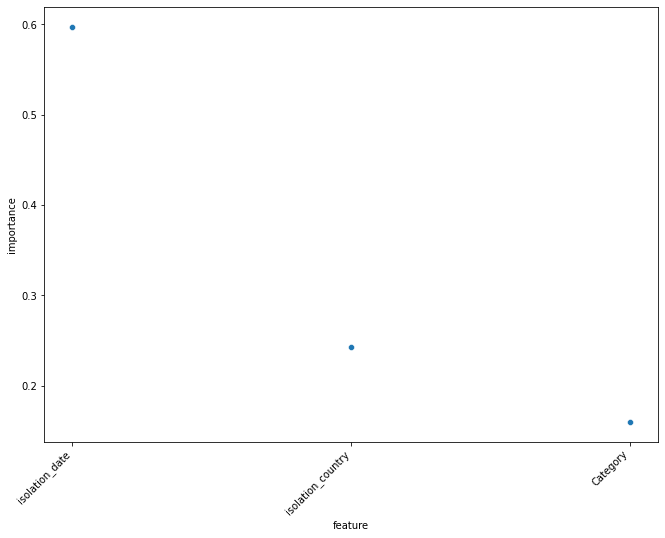

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 8))
ax = sns.scatterplot(x='feature', y='importance', data=impdf, ax=ax)
plt.xticks(rotation=45,  horizontalalignment='right')

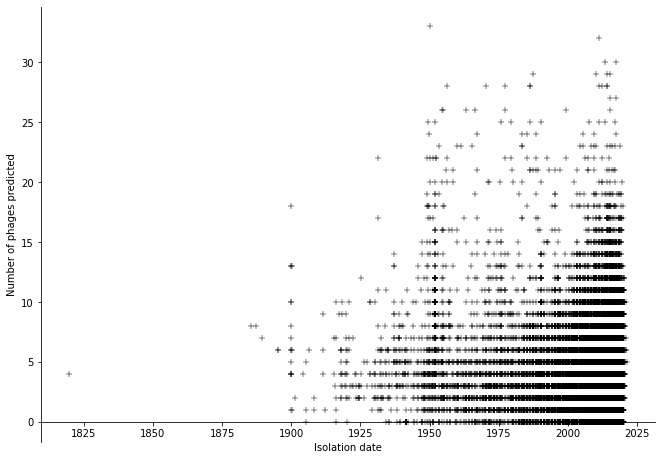

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 8))
ax = sns.scatterplot(x='isolation_date', y='Kept', data=phagemeta[phagemeta['isolation_date'] != -1], ax=ax, marker='+', color='k')
ax.set_ylabel("Number of phages predicted")
ax.set_xlabel("Isolation date")
#ax.axhline(y=0, color='k')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')



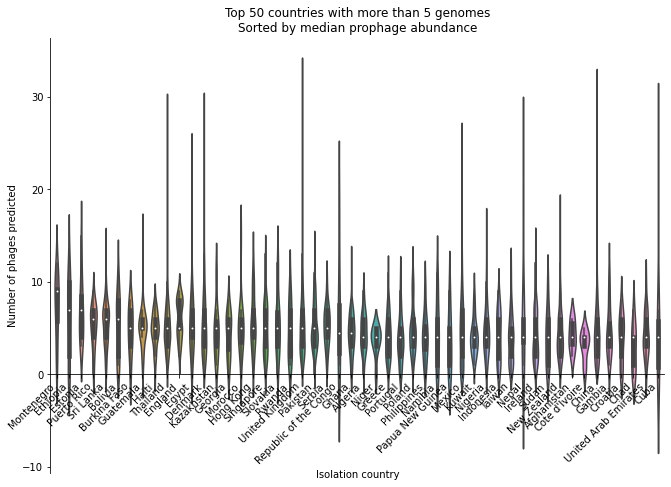

In [15]:
topnc = 50
genomen = 5 
tmpc = pd.DataFrame(phagemeta.groupby('isolation_country').count()['assembly_accession'] > genomen)
tmpc[tmpc['assembly_accession']].index
tmp = phagemeta[phagemeta['isolation_country'].isin(tmpc[tmpc['assembly_accession']].index)]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 8))
sortedorder = tmp.groupby('isolation_country')["Kept"].median().sort_values(ascending=False).index[0:topnc]
ax = sns.violinplot(x='isolation_country', y='Kept', data=tmp, ax=ax, order=sortedorder)
ax.set_ylabel("Number of phages predicted")
ax.set_xlabel("Isolation country")
#ax.axhline(y=0, color='k')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.set_title(f'Top {topnc} countries with more than {genomen} genomes\nSorted by median prophage abundance')
l = plt.xticks(rotation=45,  horizontalalignment='right')


## Big Question

Which country(s) are driving the importance of this measure in predicting the number of phages.